# Portfolio 1: Cycling GPS Data

In this portfolio you are asked to analyse some data collected from a portable GPS 
device during a number of cycling races. 

In [1]:
import pandas as pd
import utils
import math
import numpy as np
from matplotlib import pyplot as plt # Matplotlib for additional customization
%matplotlib inline
import seaborn as sns # Seaborn for plotting and styling

## Utility Function

You are provided with the definition of a function `parse_gpx` in the utils module that will read 
the XML data file and return a Pandas DataFrame.

In [2]:
df = utils.parse_gpx('data/ride1.gpx')
df.head()

,elevation,latitude,longitude
2012-09-22 21:46:56,35.6,-33.899426,150.97589
2012-09-22 21:46:56,35.6,-33.899426,150.97589
2012-09-22 21:46:56,35.6,-33.899426,150.97589
2012-09-22 21:46:56,35.6,-33.899426,150.97589
2012-09-22 21:46:56,35.6,-33.899426,150.97589


## Inspecting/Checking data

In [3]:
print(df.shape)

(1677, 3)


Since the first 5 rows are identical, remove duplicates

In [4]:
df=df.drop_duplicates()
df.head()

,elevation,latitude,longitude
2012-09-22 21:46:56,35.6,-33.899426,150.975890
2012-09-22 21:46:57,35.6,-33.899430,150.975888
2012-09-22 21:47:24,35.6,-33.899436,150.975884
2012-09-22 21:47:27,35.6,-33.899491,150.975854
2012-09-22 21:47:29,35.6,-33.899550,150.975825


In [5]:
len(df.index)

1572

105 identical rows were dropped. Now Check that all the columns are numeric:

In [6]:
print("elevation data type: ",df.elevation.dtype)
print("latitude data type: ",df.latitude.dtype)
print("longitude data type: ",df.longitude.dtype)

elevation data type:  float64
latitude data type:  float64
longitude data type:  float64


Check for missing/NaN values. Since the function dropna() in pandas do not recognise empty strings/cells as null, I will first replace any blank cells to `NaN`, then drop ALL rows containing `NaN` 

In [7]:
df.replace('', np.nan, inplace=True)
df.dropna(inplace=True)

Now lets take a look at the description of the numerical data:

In [8]:
df.describe()

,elevation,latitude,longitude
count,1572.000000,1572.000000,1572.000000
mean,34.540458,-33.898799,150.978981
std,5.104416,0.001716,0.002060
min,22.800000,-33.901209,150.975771
25%,30.600000,-33.900566,150.976901
50%,34.800000,-33.899060,150.979390
75%,38.800000,-33.896936,150.980925
max,45.000000,-33.896114,150.982015


From the descriptive stats above, we can see that we have 1572 entries. The average elevation is 34.5m and ranges from 22.8 - 45m above sea level. The elevation data is split roughly 50/50 with around half the values being below the mean and the other half being above.

The latitude and longitude have very small standard deviations which tells us that there wasnt much spread between the values. This is evident as the range of latitude is (-33.9, -33.89) and the range of longitude is (150.97, 150.98). This makes sense as Steve is travelling by bike and in a round circuit i.e. he isn't riding across the country. 

## Data Manipulation to answer questions
### Distance Formula
To calculate distances between to GPS points, I am using the below function from <a href="https://gist.github.com/rochacbruno/2883505">github</a>. Instead of calculating the distance between two points in 2D space, the **Great Circle Distance** calculates the distance on the surphace of a sphere i.e. the earth's surface.

In [10]:
from math import radians, cos, sin, asin, sqrt
def distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    #lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 

    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c #kilometre
    return km 

### Calculate Distance

This function first uses an empty list to catch all the distances. It then, using the iterrows function, itterates over each row, calculating the distance and storing it in the column". There is a place-holder variable, prev_index, which assists in calculating the distance. At the end, this list of distances is converted to a series and added to the dataframe.

In [12]:
def calculate_distance(df):
    """
    Calculate distance (by calling distance function) for each row then
    add as a column to the dataframe
    """
    #This empty list will eventually be distance column in df 
    distance_col=[]
    
    #remember what previous index was
    prev_index = df.index[0]

    for index, row in df.iterrows():
        #calculate distance in km using the distance/haverstine formula above
        distance_col.append(distance(df.latitude.loc[prev_index],
                                     df.longitude.loc[prev_index],
                                     df.latitude.loc[index],
                                     df.longitude.loc[index]))
        #update previous index for next iteration
        prev_index=index
    
    #add distane column to dataframe (by converting to a series)
    df['distance_km'] = pd.Series(distance_col, df.index) 
    
calculate_distance(df)
df.head()

,elevation,latitude,longitude,distance_km
2012-09-22 21:46:56,35.6,-33.899426,150.975890,0.000000
2012-09-22 21:46:57,35.6,-33.899430,150.975888,0.000482
2012-09-22 21:47:24,35.6,-33.899436,150.975884,0.000762
2012-09-22 21:47:27,35.6,-33.899491,150.975854,0.006713
2012-09-22 21:47:29,35.6,-33.899550,150.975825,0.007085


### Time Calculation (for each row)
In preparation for the `speed` calculation, we will first calculate the `time` of each row

In [13]:
def calculate_time(df):
    """
    For each row in dataframe, calculate the TIME between current row and previous row
    """
    #This empty list will eventually be our time column
    time_col=[]
    
    #remember what previous index was
    prev_index = df.index[0]

    #for each row, calculate the time between current row and previous row
    for index, row in df.iterrows():
        #calculate time for current row   
        start = prev_index
        finish = index
        time = (finish-start).total_seconds()
        
        #add time (in hours) to list
        time_col.append(time/60/60)

        #update previous index for next iteration
        prev_index=index

    #add the time column to the dataframe
    df['time_hr'] = pd.Series(time_col, df.index) 

calculate_time(df)
df.head()

,elevation,latitude,longitude,distance_km,time_hr
2012-09-22 21:46:56,35.6,-33.899426,150.975890,0.000000,0.000000
2012-09-22 21:46:57,35.6,-33.899430,150.975888,0.000482,0.000278
2012-09-22 21:47:24,35.6,-33.899436,150.975884,0.000762,0.007500
2012-09-22 21:47:27,35.6,-33.899491,150.975854,0.006713,0.000833
2012-09-22 21:47:29,35.6,-33.899550,150.975825,0.007085,0.000556


### Speed Calculation (for each row)
Now I will simply calculate the speed of each row using the speed = distance/time. 

In [14]:
def calculate_speed(df): 
    """
    calculate the speed for each row in dataframe
    """
    df['speed']=df['distance_km']/df['time_hr']
    df['speed'].fillna(0, inplace=True)
    
calculate_speed(df)   
df.head()

,elevation,latitude,longitude,distance_km,time_hr,speed
2012-09-22 21:46:56,35.6,-33.899426,150.975890,0.000000,0.000000,0.000000
2012-09-22 21:46:57,35.6,-33.899430,150.975888,0.000482,0.000278,1.733622
2012-09-22 21:47:24,35.6,-33.899436,150.975884,0.000762,0.007500,0.101667
2012-09-22 21:47:27,35.6,-33.899491,150.975854,0.006713,0.000833,8.055957
2012-09-22 21:47:29,35.6,-33.899550,150.975825,0.007085,0.000556,12.753849


Now that we have added the speed to each row, check descriptive statistics:
### Descriptive Statistics

In [15]:
df['speed'].describe()

count    1572.000000
mean       38.067714
std         7.064025
min         0.000000
25%        33.638492
50%        36.887376
75%        41.285999
max        61.147657
Name: speed, dtype: float64

### What is the average speed of the rider?

In [16]:
df.speed.mean()

38.06771449448306

### Plot a histogram showing distribution of speed over the course of the race

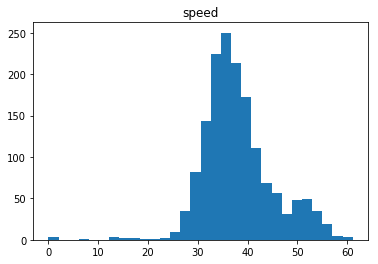

In [17]:
ax = hist = df.hist(column='speed', bins=30, grid=False)

### Calculate Gradient
Gradient is the change in elevation per unit of distance. 
I have already calculated the distance

Since the elevation for each measurement is given, I will simply compute the change for each row

In [18]:
def calculate_gradient(df):
    #empty list to form gradeint column.
    gradient_col = []
    
    #remember what previous index was
    prev_index = df.index[0]

    #iterate over dataframe
    for index, row in df.iterrows():
        #if distance is 0, gradient is 0
        if(df.loc[index].distance_km == 0):
            gradient=0
        else:
            #calculate elevation
            elevation_change = df.loc[index].elevation - df.loc[prev_index].elevation
            #calculate gradient
            gradient = elevation_change/(df.loc[index].distance_km*1000) #metres
            
        gradient_col.append(gradient)

        #update previous index for next iteration
        prev_index=index

    index=df.index 
    df['gradient'] = pd.Series(gradient_col, df.index) 
    
calculate_gradient(df)
df.tail()

,elevation,latitude,longitude,distance_km,time_hr,speed,gradient
2012-09-22 22:42:30,42.4,-33.900135,150.975999,0.016388,0.000833,19.666091,0.024407
2012-09-22 22:42:32,42.8,-33.900193,150.976058,0.008441,0.000556,15.193182,0.047390
2012-09-22 22:42:34,43.0,-33.900252,150.976106,0.007916,0.000556,14.249089,0.025265
2012-09-22 22:42:36,43.0,-33.900313,150.976154,0.008101,0.000556,14.582556,0.000000
2012-09-22 22:42:38,43.2,-33.900369,150.976203,0.007696,0.000556,13.852529,0.025988


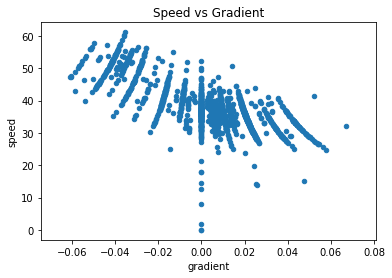

In [19]:
df.plot.scatter(x='gradient', y='speed', title="Speed vs Gradient")

**Comment** There appears to be a negative relationship between gradient and speed which suggests that as gradient increases, speed *decreases*.

## How many laps did the rider complete in the race?
According to <a href='http://www.bankstownsportscycling.com/road.html'> Bankstown Sports cycling </a>, the track at Landsdowne Park is 2.1km. 

In [20]:
#total_distance = df['distance_km'].sum()

#print("Total number laps is: ",total_distance/2.1)

Total number laps is:  16.599502857620337


In [59]:
lapdf = df.round(4)

def count_laps(df):
    """
    Calculate number of laps by counting number times rider cross
    a certain latitude measurement. This is divided by 2 as its a track
    """
    #count number of laps
    laps=0
    start_lat = df.iloc[0].latitude

    for index, row in df.iterrows():
        if(df.latitude[index] in [start_lat, start_lat+0.00001, start_lat-0.00001]):
            laps=laps+1

    return (laps/2)

count_laps(lapdf)

20.0

In [57]:
lapdf.head()

,elevation,latitude,longitude,distance_km,time_hr,speed
2017-08-19 21:49:42,-0.2,-33.89971,150.97578,0.00000,0.00000,0.00000
2017-08-19 21:49:43,-0.2,-33.89972,150.97578,0.00190,0.00028,6.83750
2017-08-19 21:49:44,-0.2,-33.89975,150.97577,0.00268,0.00028,9.65881
2017-08-19 21:49:45,-0.2,-33.89977,150.97577,0.00302,0.00028,10.88955
2017-08-19 21:49:46,-0.2,-33.89980,150.97577,0.00334,0.00028,12.01365


# =====Challenge=====
## 1. Clean up data


In [21]:
df1=df.copy()
df2 = utils.parse_gpx('data/ride2.gpx') 
df3 = utils.parse_gpx('data/ride3.gpx')
df4 = utils.parse_gpx('data/ride4.gpx')
df5 = utils.parse_gpx('data/ride5.gpx')
df6 = utils.parse_gpx('data/ride6.gpx')
df7 = utils.parse_gpx('data/ride7.gpx')
df8 = utils.parse_gpx('data/ride8.gpx')
df9 = utils.parse_gpx('data/ride9.gpx')


for df in (df1, df2, df3, df4, df5, df6, df7, df8, df9):
    #cleanup
    df.drop_duplicates(inplace=True)
    df.replace('', np.nan, inplace=True)
    df.dropna(inplace=True)
    
    #calculate speeds
    calculate_distance(df)
    calculate_time(df)
    calculate_time(df)
    calculate_speed(df) 


## 2. Tabulate the average speeds of the races and the date of each race

In [22]:
dates_col = []
avgspeed = []

#go through every dataframe
for df in (df1, df2, df3, df4, df5, df6, df7, df8, df9):
    dates_col.append(df.index[0].date())
    avgspeed.append(df.speed.mean())

#add dates as a column    
speedsdf = pd.DataFrame(dates_col, columns=['dates'])
speedsdf.set_index('dates')
#add speeds as a column  
speedsdf['avg_speed'] = pd.Series(avgspeed, speedsdf.index) 

#order by date
speedsdf = speedsdf.sort_values(by='dates')


speedsdf.set_index('dates',inplace=True)
speedsdf

,avg_speed
dates,
2011-08-27,37.081445
2012-09-22,38.067714
2012-12-29,36.670200
2013-09-28,38.057442
2014-12-27,38.176819
2016-04-02,38.190115
2017-02-18,35.795556
2017-08-19,34.445185
2017-09-02,36.943282


## Plot speed vs date - do I get faster or slower?

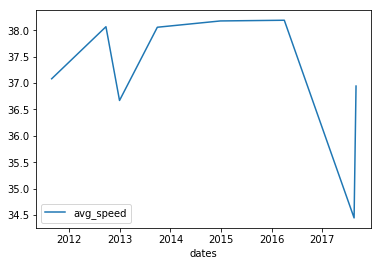

In [23]:
speedsdf.plot.line()

### Answer: Slower